# Sheet 7

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

# 1) Log-sum-exp and softmax

(b)

In [74]:
def logsumexp(x, lamb=1):
    assert lamb != 0
    return 1/lamb * torch.log(torch.exp(lamb * x).sum(dim=-1))

# TODO: set up a grid of points in [-1, 1] x [-1, 1]


# TODO: I recommend you set up a function to set up an Axes object with the correct x, y labels, 
#       equal aspect and maybe x and y ticks.

def set_up_axes(ax):
    ...
    
# TODO: calculate and plot the functions as specified in the task


In [69]:
xx, yy = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
zz = torch.tensor(np.stack([xx, yy], axis=-1))

Text(0.5, 1.0, 'max function')

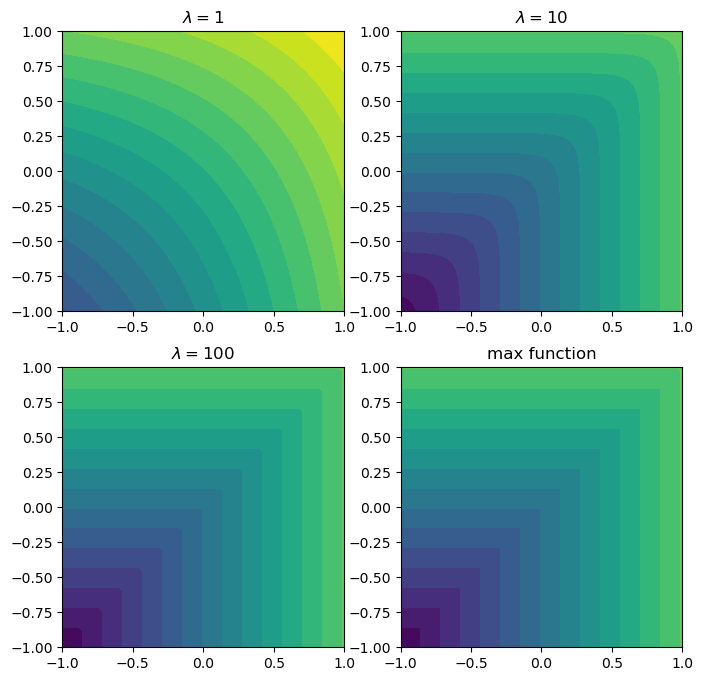

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
levels = np.linspace(-1, 1.7, 20)
axes[0, 0].contourf(xx, yy, logsumexp(zz, lamb=1).detach().numpy(), levels=levels)
axes[0, 0].set_title("$\lambda = 1$")
axes[0, 1].contourf(xx, yy, logsumexp(zz, lamb=10).detach().numpy(), levels=levels)
axes[0, 1].set_title("$\lambda = 10$")
axes[1, 0].contourf(xx, yy, logsumexp(zz, lamb=100).detach().numpy(), levels=levels)
axes[1, 0].set_title("$\lambda = 100$")

axes[1, 1].contourf(xx, yy, np.max(np.stack([xx, yy], axis=-1), axis=-1), levels=levels)
axes[1, 1].set_title("max function")

In [95]:
np.max(np.stack([xx, yy], axis=-1), axis=-1)

array([[-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [-0.97979798, -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [-0.95959596, -0.95959596, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       ...,
       [ 0.95959596,  0.95959596,  0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [ 0.97979798,  0.97979798,  0.97979798, ...,  0.97979798,
         0.97979798,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

(c)

In [ ]:
def softmax(x, axis, lamb=1):
    # TODO: implement the softmax function. Axis should specify along which axis the sums should be computed.

        
# TODO: compute the argmax of each gridpoint in one-hot form
onehot_argmax = to_onehot(np.argmax(xy, axis=-1))

# TODO: make the plots as specified on the sheet (nicest is in a grid which you can get using plt.subplots)

# plot the softmax
fig, axs = plt.subplots(2, 4, figsize=(17, 7))
        
# plot the onehot argmax


# 2) Top tagging with Point Clouds

See https://github.com/heidelberg-hepml/ml-tutorials for solutions

## Taking Input

In [7]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

# shape: (events, particles, 4-momenta)
# 4-momenta are ordered as (E, px, py, pz)
# y are the labels (1 for signal=top jet, 0 for background=QCD jet)
print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


## Preprocessing Code

In [5]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot

In [6]:
# function to convert the jet to a particle cloud
def constit_to_cloud( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt( pxs**2+pys**2 )
    
    print( "Calculating eta" )
    etas  = eta( pT, pzs )
    
    print( "Calculating phi" )
    phis  = phi( pxs, pys )
    
    print( "Calculating the mass" )
    E_tot = E.sum( axis=1 )
    px_tot = pxs.sum( axis=1 )
    py_tot = pys.sum( axis=1 )
    pz_tot = pzs.sum( axis=1 )
    j_mass = mass( E_tot, px_tot, py_tot, pz_tot )
    
    print( "Pre-shifting the phis" )
    phis = ( phis.T - phis[:,0] ).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    cloud = np.stack( [ pT/np.mean(pT), etas, phis ], axis=2 )
    
    return cloud

## Preprocessing Output
50 constituents each with $(p_T, \eta, \phi)$

In [8]:
z_train = constit_to_cloud( X_train, 50, True, True, True )
z_val = constit_to_cloud( X_val, 50, True, True, True )
z_test = constit_to_cloud( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing


In [29]:
class Jet_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data)
        self.labels = torch.tensor(labels).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [30]:
trn_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_train, y_train), batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_val, y_val), batch_size=128, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(Jet_Dataset(z_test, y_test), batch_size=128, shuffle=False)

## Transformer Network

In [48]:


class JetTransformer( torch.nn.Module ):
    
    def __init__( self, *, input_dim, embed_dim, num_heads ):
        super( JetTransformer, self ).__init__()
        
        self.lin_embed = nn.Linear( input_dim, embed_dim )
        
        self.transformer_layer_1 = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads, 
            batch_first=True,
            dropout=0.2,
            dim_feedforward=embed_dim
        )
        
        self.transformer_layer_2 = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads, 
            batch_first=True,
            dropout=0.2,
            dim_feedforward=embed_dim
        )
        
        self.head_network = nn.Sequential( 
            nn.Linear( embed_dim, embed_dim ),
            nn.ReLU(),
            nn.Linear( embed_dim, 1 )
        )
        
    def forward( self, batch ):

        x = self.lin_embed( batch )
        x = self.transformer_layer_1( x )
        x = self.transformer_layer_2( x )
        x = x.sum( dim=1 )
        x = self.head_network( x )

        return nn.functional.sigmoid( x )



## Train

In [49]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [50]:
def batch_loss(model, x, y, loss_fn):
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    return loss_fn(y_pred.flatten(), y)

In [51]:
def train_epoch(model, dataloader, losses, batch_loss_fn, loss_fn, optimizer):
    # run for each epoch (and ran over all data)
    for x, y in dataloader:
        # loading in batches of batchsize
        optimizer.zero_grad()
        loss = batch_loss_fn(model, x, y, loss_fn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [52]:
model = JetTransformer( input_dim=3, embed_dim=12, num_heads=3 ).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
validation_losses = []
for epoch in tqdm(range(20)):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss, loss_fn, optimizer)
    with torch.no_grad():
        validation_losses.append(
            np.mean([batch_loss(model, x, y, loss_fn).detach().numpy() for x, y in val_dataloader])
        )

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:09<00:00,  9.49s/it]


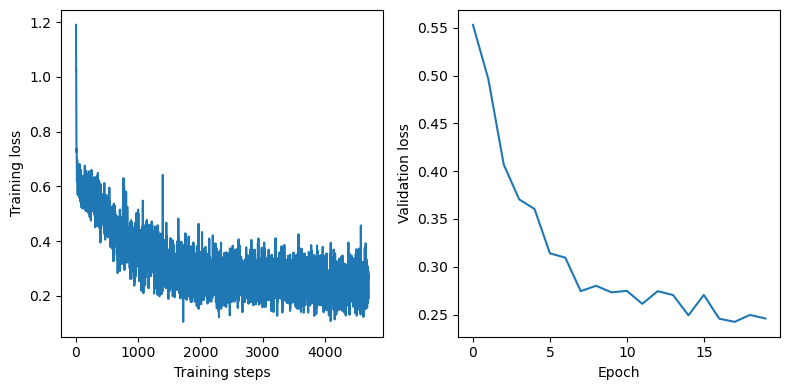

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(train_losses)
ax2.plot(validation_losses)
ax1.set_xlabel("Training steps")
ax2.set_xlabel("Epoch")
ax1.set_ylabel("Training loss")
ax2.set_ylabel("Validation loss")
plt.tight_layout()

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

In [54]:
with torch.no_grad():
    y_pred = model(torch.tensor(z_test).to(device).to(torch.float32)).detach().cpu().numpy().flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

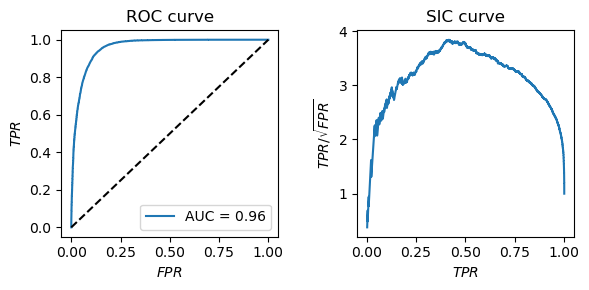

In [55]:
# create figure and two subplots
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# plot ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
ax[0].plot([0, 1], [0, 1], "--", color="black")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("$FPR$")
ax[0].set_ylabel("$TPR$")
ax[0].legend(loc='lower right')

# plot SIC curve
ax[1].plot(tpr[fpr != 0], tpr[fpr != 0]/np.sqrt(fpr[fpr != 0]))
ax[1].set_title("SIC curve")
ax[1].set_xlabel("$TPR$")
ax[1].set_ylabel("$TPR/\sqrt{{FPR}}$")

plt.tight_layout()
plt.show()

# 3) CNNs for Galaxy Classification

## Getting the data

In [2]:
import h5py
import numpy as np
import torch

label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data07/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

print(labels.shape, images.shape)
# TODO: print the number of samples for each class
for i, c in enumerate(label_names):
    print(f'{c}: {torch.sum(labels == i).item()}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])
torch.Size([21785]) torch.Size([21785, 3, 69, 69])
Disk, Face-on, No Spiral: 3461
Smooth, Completely round: 6997
Smooth, in-between round: 6292
Smooth, Cigar shaped: 349
Disk, Edge-on, Rounded Bulge: 1534
Disk, Edge-on, Boxy Bulge: 17
Disk, Edge-on, No Bulge: 589
Disk, Face-on, Tight Spiral: 1121
Disk, Face-on, Medium Spiral: 906
Disk, Face-on, Loose Spiral: 519


## Preparing Data

### Visualising the data

We notice that the values are stored as float32 with values from 0 to 255, so we can convert to unsigned 8-bit integers.

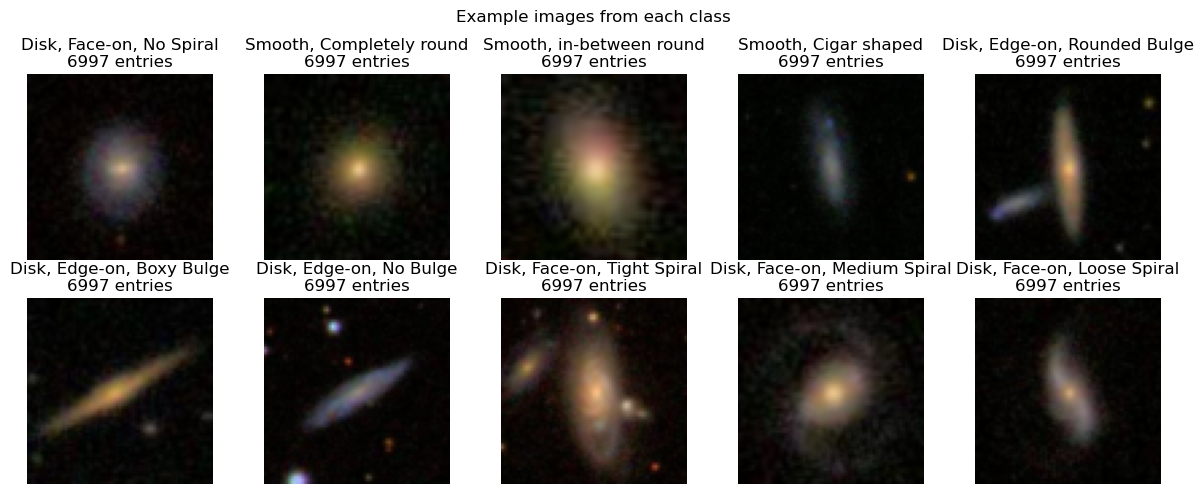

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, c in enumerate(label_names):
    # plot the first image of each class
    # note that we need to transpose the image to get the correct color channels (imshow uses (height, width, channel))
    # convert to uint8 to get the correct color range (could also scale to [0, 1] and use float32])
    axes[i//5, i%5].imshow(images[labels == i][0].detach().numpy().transpose(1, 2, 0).astype(np.uint8))
    axes[i//5, i%5].set_title(f"{c}\n{torch.sum(labels==1).item()} entries")
    axes[i//5, i%5].axis('off')
fig.suptitle("Example images from each class")
plt.tight_layout()

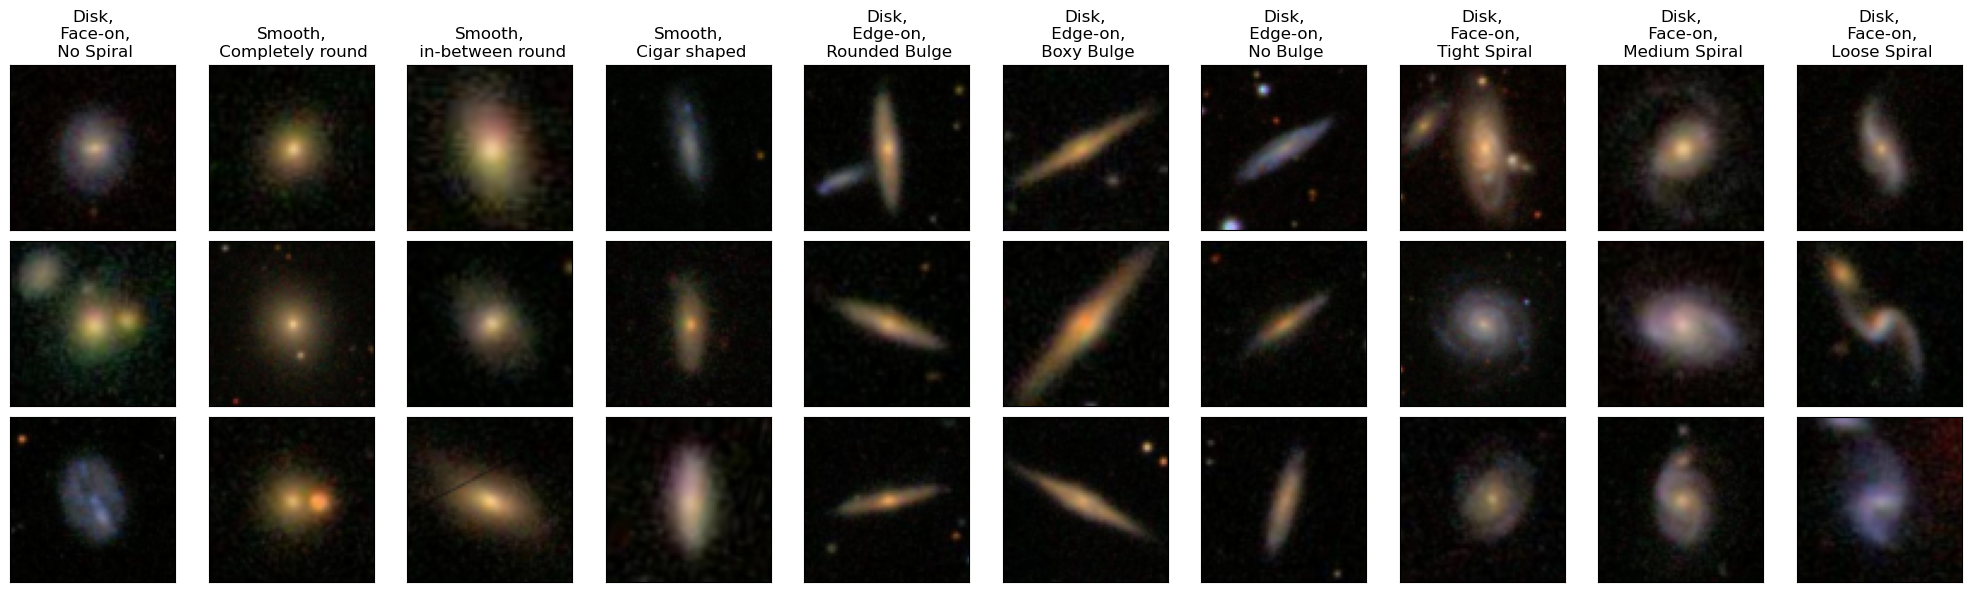

In [5]:
from matplotlib import pyplot as plt

# TODO: plot some samples of each class
itemindex = torch.where(labels == 3)
itemindex[:3]

samples_per_class = 3
fig, axss = plt.subplots(samples_per_class, n_classes, figsize=(n_classes * 2, samples_per_class * 2))
for label, (label_name, axs) in enumerate(zip(label_names, axss.T)):
    idx = torch.where(labels==label)[0][:samples_per_class] # take samples_per_class first occurences
    for i, (ind, ax) in enumerate(zip(idx, axs)):
        ax.imshow(images[ind].long().moveaxis(0, -1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title(label_name.replace(',',',\n'))
plt.tight_layout()
plt.show()

### Normalise Images

In [3]:
from torchvision.transforms import Normalize

# TODO: Compute the mean and standard deviation per channel over the dataset

stds = images.moveaxis(1, 0).reshape(3, -1).std(axis=1)
means = images.moveaxis(1, 0).reshape(3, -1).mean(axis=1)
# stds, means = torch.tensor([37.5412, 31.3756, 26.3283]), torch.tensor([27.7014, 23.8241, 18.1425])
print(stds, means)

# TODO: Normalize the images
normalize = Normalize(means, stds)
images_normalized = normalize(images)

tensor([37.5412, 31.3756, 26.3283]) tensor([27.7014, 23.8241, 18.1425])


## (a) Implement CNN

In [15]:
class Galaxy_Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.labels_onehot = F.one_hot(labels, n_classes).float()

    def __len__(self):
        return len(self.labels_onehot)

    def __getitem__(self, index):
        image = self.images[index]
        label_onehot = self.labels_onehot[index]

        return image, label_onehot

In [16]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

n_samples = len(labels)

# TODO: split the data in training and validation sets, stratifying by the labels
train_idx, val_idx = train_test_split(np.arange(n_samples), test_size=0.1, stratify=labels)

# TODO: create pytorch datasets for training and validation
train_dataset = Galaxy_Dataset(images_normalized[train_idx].float(), labels[train_idx].long())
val_dataset = Galaxy_Dataset(images_normalized[val_idx].float(), labels[val_idx].long())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

#TODO: implement a small CNN as specified on the sheet
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input is 3 channels of 69x69 pixels
        self.in_channels = 3
        self.image_shape = (69, 69)
        self.n_classes = n_classes
        # kernel 5, 8 output feature maps, relu and maxpool
        self.cnn1 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Conv2d(3, 8, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # kernel 5, 16 output feature maps, relu and maxpool
        self.cnn2 = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Conv2d(8, 16, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Calculate the final size after convolutions and pooling
        with torch.no_grad():
            # Create a dummy input to pass through the CNN layers to calculate output size
            dummy_input = torch.zeros(1, self.in_channels, *self.image_shape)
            dummy_output = self.cnn2(self.cnn1(dummy_input))
            self.final_convolutional_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

        # flatten into single vector, followed by MLP with 2 hidden layers of size 64 and 32
        # we add a softmax activation to the last layer to get probabilities
        # this gives probabilities for each class but they add up to 1
        self.flattening = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Flatten(),
            nn.Linear(self.final_convolutional_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(32, self.n_classes),
            nn.Softmax(dim=1)
        )

        self.main = nn.Sequential(
            self.cnn1,
            self.cnn2,
            self.flattening,
            self.classifier
        )
    
    def forward(self, x):
        return self.main(x)


## (b)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [12]:
def batch_loss(model, x, y, loss_fn):
    x, y = x.to(device), y.to(device)
    y_pred = model(x)  # shape: (batch_size, n_classes)
    # DO NOT flatten y_pred
    return loss_fn(y_pred, y)

In [13]:
def train_epoch(model, dataloader, losses, batch_loss_fn, loss_fn, optimizer):
    # run for each epoch (and ran over all data)
    for x, y in dataloader:
        # loading in batches of batchsize
        optimizer.zero_grad()
        loss = batch_loss_fn(model, x, y, loss_fn)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [17]:
model = CNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train_losses = []
validation_losses = []
for epoch in tqdm(range(10)):
    train_losses = train_epoch(model, train_loader, train_losses, batch_loss, loss_fn, optimizer)
    validation_losses.append(
        np.mean([batch_loss(model, x, y, loss_fn).detach().numpy() for x, y in val_loader])
    )

  0%|          | 0/3 [00:00<?, ?it/s]/home/anton/.anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
100%|██████████| 3/3 [00:52<00:00, 17.49s/it]


In [18]:
from sklearn.metrics import confusion_matrix


In [47]:
def calc_raw_y(model, val_loader):
    y_val_pred, y_val_true = [], []
    for x, y in val_loader:
        y_val_pred.append(model(x.to(device)).detach().cpu().numpy())
        y_val_true.append(y.detach().cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred)
    y_val_true = np.concatenate(y_val_true)
    return y_val_true, y_val_pred

In [56]:
y_val_true, y_val_pred = calc_raw_y(model, val_loader)
cm = confusion_matrix(np.argmax(y_val_true, axis=1), np.argmax(y_val_pred, axis=1))
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

/home/anton/.anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


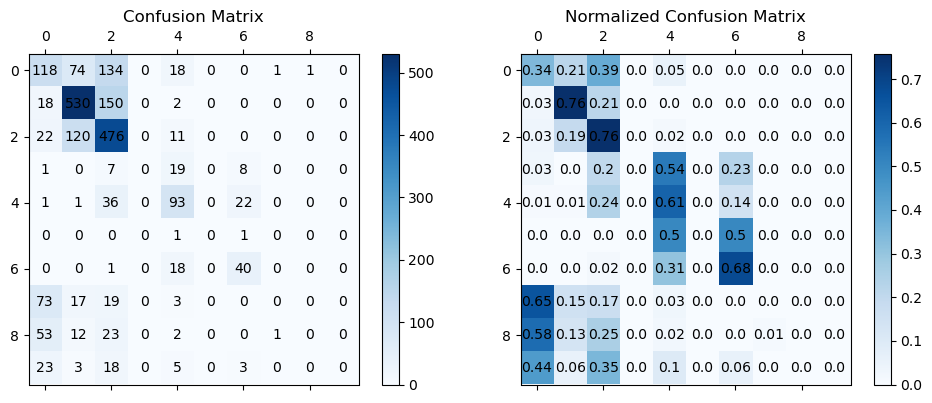

In [49]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.matshow(cm, cmap=plt.cm.Blues, fignum=False)
plt.title('Confusion Matrix')
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.subplot(1, 2, 2)
plt.matshow(cm_normalized, cmap=plt.cm.Blues, fignum=False)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(x=j, y=i, s=round(cm_normalized[i, j], 2), va='center', ha='center')

plt.tight_layout()
plt.show()

In [57]:
accuracy_cnn = np.sum(np.argmax(y_val_true, axis=1) == np.argmax(y_val_pred, axis=1)) / len(y_val_true)
print(f"CNN accuracy: {accuracy_cnn:.2f}")

CNN accuracy: 0.55


## (c) ResNet

In [34]:
# TODO: redo (c) with a ResNet
# Hint: Training is probably quicker on google colab (https://colab.research.google.com/)
from torchvision.models import resnet34

In [41]:
ResNet = resnet34(pretrained=True).to(device)
ResNet.fc = nn.Sequential(
    nn.Linear(ResNet.fc.in_features, n_classes),
    nn.Softmax(dim=1)
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(ResNet.parameters(), lr=1e-3)
train_losses = []
validation_losses = []
for epoch in tqdm(range(3)):
    train_losses = train_epoch(ResNet, train_loader, train_losses, batch_loss, loss_fn, optimizer)
    validation_losses.append(
        np.mean([batch_loss(ResNet, x, y, loss_fn).detach().numpy() for x, y in val_loader])
    )

/home/anton/.anaconda3/envs/mlenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anton/.anaconda3/envs/mlenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 3/3 [26:15<00:00, 525.07s/it]


In [51]:
y_val_true, y_val_pred = calc_raw_y(ResNet, val_loader)
cm = confusion_matrix(np.argmax(y_val_true, axis=1), np.argmax(y_val_pred, axis=1))
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

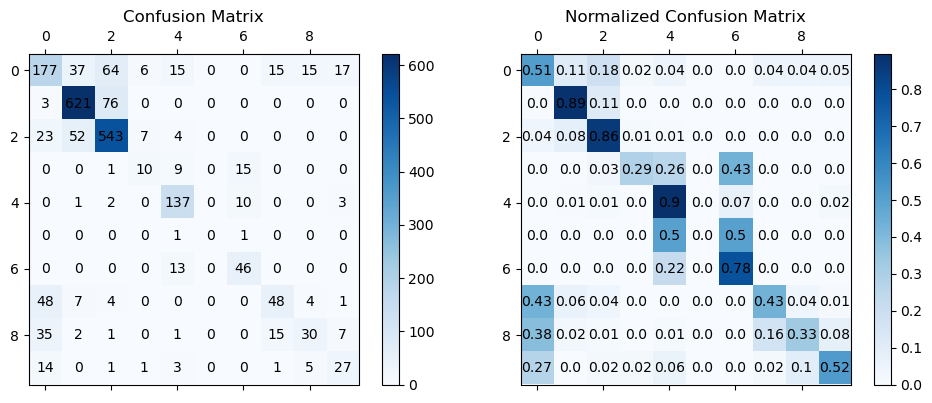

In [52]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.matshow(cm, cmap=plt.cm.Blues, fignum=False)
plt.title('Confusion Matrix')
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], va='center', ha='center')

plt.subplot(1, 2, 2)
plt.matshow(cm_normalized, cmap=plt.cm.Blues, fignum=False)
plt.title('Normalized Confusion Matrix')
plt.colorbar()
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        plt.text(x=j, y=i, s=round(cm_normalized[i, j], 2), va='center', ha='center')

plt.tight_layout()
plt.show()

In [55]:
accuracy_resnet = np.sum(np.argmax(y_val_true, axis=1) == np.argmax(y_val_pred, axis=1)) / len(y_val_true)
print(f"ResNet accuracy: {accuracy_resnet:.2f}")

ResNet accuracy: 0.75


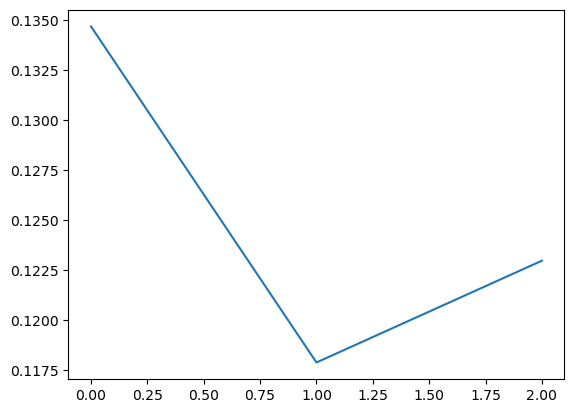

In [42]:
plt.plot(validation_losses)

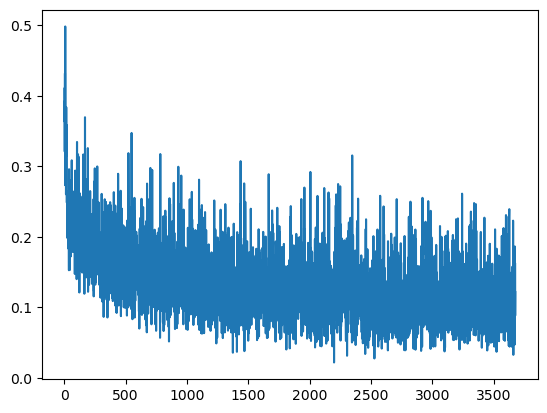

In [43]:
plt.plot(train_losses)